In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
from collections import defaultdict

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
from collections import defaultdict


def load_energy_data():
    """
    Load energy history data into a structured dictionary.
    """
    dict_df = defaultdict(list)
    for file in glob.glob("../output/energy_history_*.csv"):
        # Extract strategies and user count from file name
        parts = file.split("_")
        power_strategy = parts[2].strip()
        assignment_strategy = parts[3].strip()
        user_count = int(parts[4].replace(".csv", "").strip())

        # Create a normalized combined strategy key
        strategy_key = f"{power_strategy} + {assignment_strategy}"

        # Read the file into a DataFrame
        df = pd.read_csv(file)
        dict_df[strategy_key].append(
            {"user_count": user_count, "file_name": file, "data": df}
        )
    return dict_df


def plot_energy(
    dict_df,
    power_strategy,
    assignment_strategy,
    user_count,
    mode="cumulative",
    include_nodes=None,
    exclude_nodes=None,
    bins=20,
):
    """
    Plot energy consumption or cumulative energy for selected strategies on the same graph.

    Parameters:
        dict_df (dict): Dictionary containing energy data.
        power_strategy (list): List of power strategies to filter.
        assignment_strategy (list): List of assignment strategies to filter.
        user_count (int): The user count to filter.
        mode (str): "cumulative" for cumulative energy, "per_tick" for energy consumption per tick.
        include_nodes (list): List of nodes to include in the visualization.
        exclude_nodes (list): List of nodes to exclude from the visualization.
        bins (int): Number of bins for histogram visualization.
    """
    plt.figure(figsize=(10, 6))
    matching_keys = []

    # Define different line styles and markers
    line_styles = [
        ("solid", "o"),
        ("dashed", "s"),
        ("dashdot", "^"),
        ("dotted", "D"),
        ("-", "v"),
        ("--", "p"),
    ]

    for idx, (ps, as_) in enumerate(
        [(p, a) for p in power_strategy for a in assignment_strategy]
    ):
        strategy_key = f"{ps} + {as_}"

        # Find matching runs
        runs = dict_df.get(strategy_key, [])
        selected_run = next(
            (run for run in runs if run["user_count"] == user_count), None
        )

        if not selected_run:
            print(
                f"\nNo run found for strategy '{strategy_key}' with {user_count} users."
            )
            continue

        matching_keys.append(strategy_key)

        # Extract data and filter nodes
        df = selected_run["data"]
        print(f"\nSelected file: {selected_run['file_name']}")
        if include_nodes:
            df = df[include_nodes]
        elif exclude_nodes:
            df = df.drop(columns=df.filter(regex="|".join(exclude_nodes)).columns)
        else:
            # By default, exclude user-specific data
            df = df.drop(columns=df.filter(regex="^User").columns)

        # Compute energy (per tick or cumulative)
        if mode == "cumulative":
            energy = df.sum(axis=1).cumsum()  # Cumulative energy
            label = f"{ps} + {as_} (Cumulative)"
        elif mode == "per_tick":
            energy = df.sum(axis=1)  # Energy per tick
            label = f"{ps} + {as_} (Per Tick)"
        else:
            print(f"Unsupported mode: {mode}. Use 'cumulative' or 'per_tick'.")
            return

        # Use different line style and marker for each line
        line_style, marker = line_styles[idx % len(line_styles)]
        plt.plot(
            energy,
            label=label,
            linestyle=line_style,
            marker=marker,
            markersize=8,
            markevery=int(len(energy) / 10),
        )  # Show marker every 10% of data points

    if not matching_keys:
        print("\nNo matching runs found for the specified strategies and user count.")
        return

    # Finalize and show the plot
    plt.title(
        f"Energy Visualization ({mode.capitalize()}) for User Count: {user_count}"
    )
    plt.xlabel("Time (tick)")
    plt.ylabel("Energy (J)" if mode == "per_tick" else "Cumulative Energy (J)")
    plt.legend(title="Strategies")
    plt.grid(True)
    plt.tight_layout()  # Adjust layout to prevent legend cutoff
    plt.show()

In [8]:
dict_df = load_energy_data()
len(dict_df)

7


Selected file: ../output\energy_history_OnDemand_ClosestNodeAssignment_100.csv

Selected file: ../output\energy_history_OnDemand_DE_100.csv

Selected file: ../output\energy_history_OnDemand_GA_100.csv

Selected file: ../output\energy_history_OnDemand_HAPSOnlyAssignment_100.csv

Selected file: ../output\energy_history_OnDemand_PSO_100.csv

Selected file: ../output\energy_history_OnDemand_QLearningAssignment_100.csv

Selected file: ../output\energy_history_OnDemand_TimeGreedyAssignment_100.csv


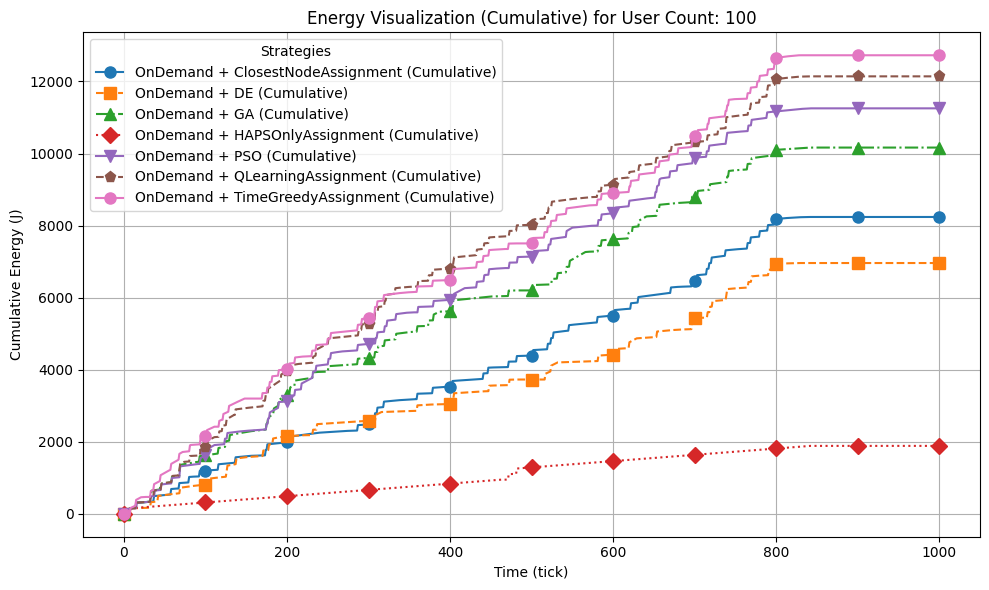

In [9]:
# Example: Plot cumulative energy for selected strategies and assignments
plot_energy(
    dict_df,
    power_strategy=["OnDemand"],
    assignment_strategy=[
        "ClosestNodeAssignment",
        "DE",
        "GA",
        "HAPSOnlyAssignment",
        "PSO",
        "QLearningAssignment",
        "TimeGreedyAssignment",
    ],
    user_count=100,
    mode="cumulative",  # "cumulative" or "per_tick"
    # include_nodes=["HAPS 0"]  # Optional: Include specific nodes
)

In [10]:
# Example: Plot energy consumption per tick
plot_energy(
    dict_df,
    power_strategy=["All On Strategy", "random"],
    assignment_strategy=["timeGreedy"],
    user_count=100,
    mode="per_tick",  # "cumulative" or "per_tick"
    exclude_nodes=["LEO 0"],  # Optional: Exclude specific nodes
)


No run found for strategy 'All On Strategy + timeGreedy' with 100 users.

No run found for strategy 'random + timeGreedy' with 100 users.

No matching runs found for the specified strategies and user count.


<Figure size 1000x600 with 0 Axes>